In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-05-25 15:28:09.638327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train_set, y_train_set), (x_test, y_test) = cifar10.load_data()

x_train_set = x_train_set.astype(np.float32)/255.0 # to match the gernated fake data type
x_test = x_test.astype(np.float32)/255.0

In [3]:
# (check data)
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

[2]


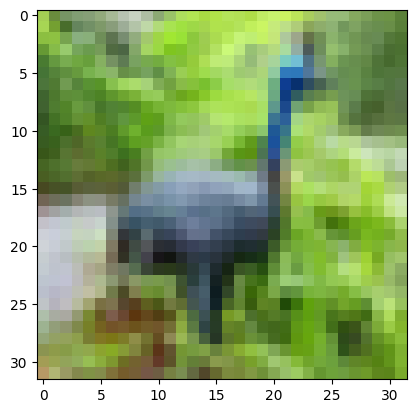

In [4]:
i = 6
print(y_train_set[i])
plt.imshow(x_train_set[i])
plt.show()

In [5]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_set, y_train_set, test_size=.1, random_state = 1)
x_train.shape, x_valid.shape

((45000, 32, 32, 3), (5000, 32, 32, 3))

### 1. GANs

#### 1.1 Build Model

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

d = 30

In [7]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[d]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(32*32*3, activation="sigmoid"), # to match training image, which already transformed [0,255] -> [0,1]
    keras.layers.Reshape([32,32,3])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32,32,3]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

2023-05-25 15:28:16.548827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 15:28:16.888799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6451 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         482122    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 476151    
                                                                 
Total params: 958,273
Trainable params: 958,273
Non-trainable params: 0
_________________________________________________________________


#### 1.2 Compile

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

#### 1.3 Train 

In [10]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) # prefetch: prepare for next training batch

In [27]:
def plot_multiple_images(images, n=None, size=1, conv=False):
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    if conv:
        images = (images+1)/2
    plt.figure(figsize=(n*size,size))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [12]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50, conv=False):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) 
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # concat fake and real images
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)      # label fake and real images
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        
        plot_multiple_images(generated_images, 10, conv=conv) 

Epoch 1/5


2023-05-25 15:28:19.135530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-25 15:28:19.399124: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55c2a5baf040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-25 15:28:19.399139: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-25 15:28:19.401998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-25 15:28:19.461904: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


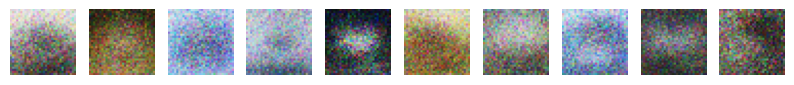

Epoch 2/5


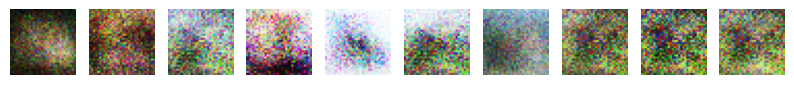

Epoch 3/5


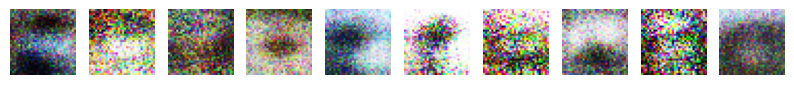

Epoch 4/5


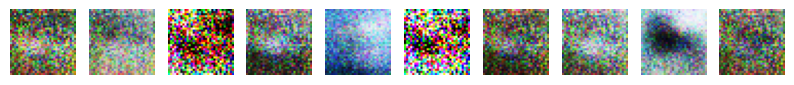

Epoch 5/5


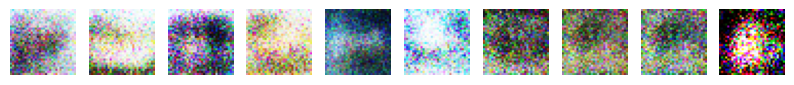

In [13]:
train_gan(gan, dataset, batch_size, d, n_epochs=5)

#### 1.4 Generate

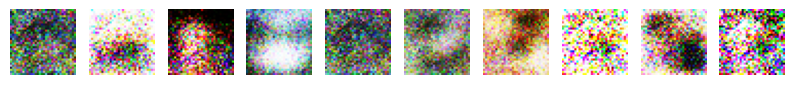

In [14]:
tf.random.set_seed(1)
np.random.seed(1)

noise = tf.random.normal(shape=[10,d])
generated_images = generator(noise)
plot_multiple_images(generated_images, 10)

### 2. DCGANs

#### 2.1 Build Model

In [15]:
np.random.seed(1)
tf.random.set_seed(1)

d = 30

In [16]:
generator = keras.models.Sequential([
    keras.layers.Dense(8*8*256, input_shape=[d]),
    keras.layers.Reshape([8,8,256]),
    keras.layers.BatchNormalization(),
    # 8x8 -> 32x32
    keras.layers.Conv2DTranspose(128,kernel_size=4, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME",
                                 activation="tanh"), # [-1,1]
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32,32,3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

#### 2.2 Compile

In [17]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

#### 2.3 Train 

In [18]:
X_train_dcgan = x_train.reshape(-1,32,32,3)*2.-1. # [0,1] -> [-1,1]

In [19]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan )
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) # prefetch: prepare for next training batch

Epoch 1/20


2023-05-25 15:30:00.238947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-05-25 15:30:01.444406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-25 15:30:02.156176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/sequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


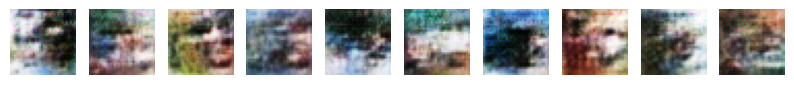

Epoch 2/20


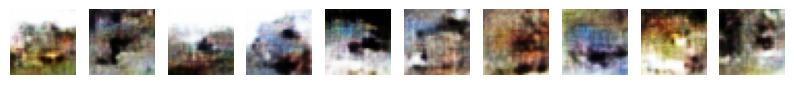

Epoch 3/20


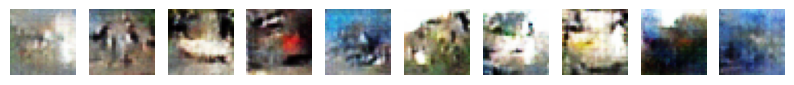

Epoch 4/20


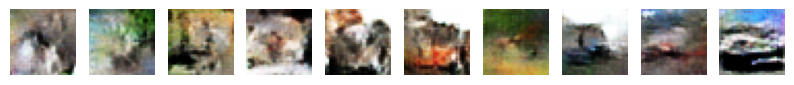

Epoch 5/20


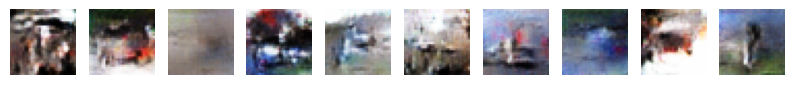

Epoch 6/20


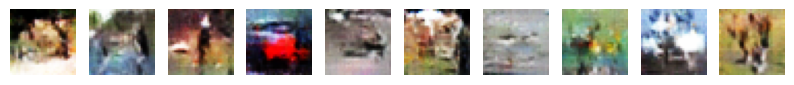

Epoch 7/20


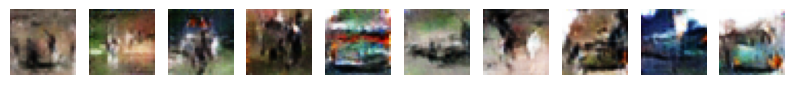

Epoch 8/20


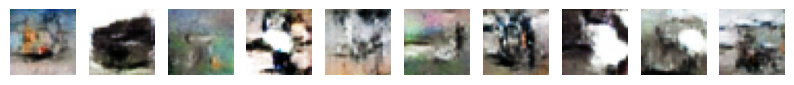

Epoch 9/20


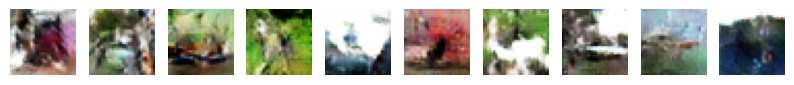

Epoch 10/20


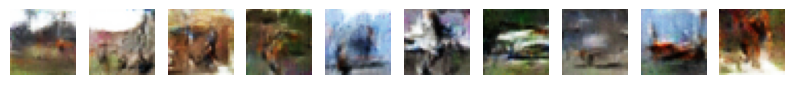

Epoch 11/20


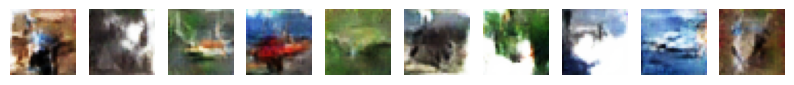

Epoch 12/20


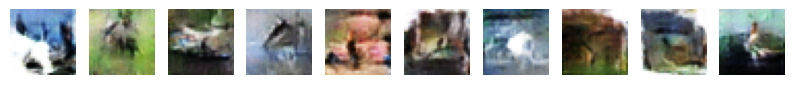

Epoch 13/20


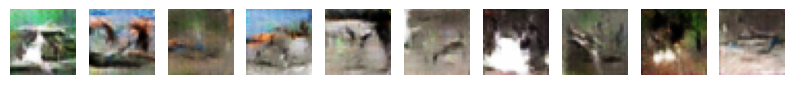

Epoch 14/20


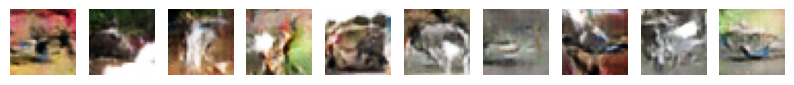

Epoch 15/20


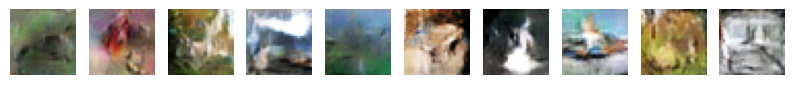

Epoch 16/20


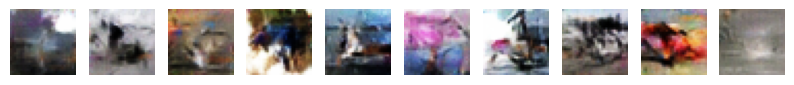

Epoch 17/20


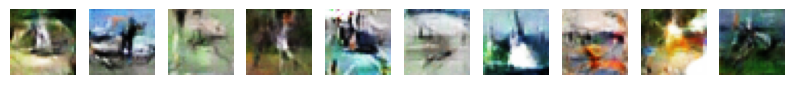

Epoch 18/20


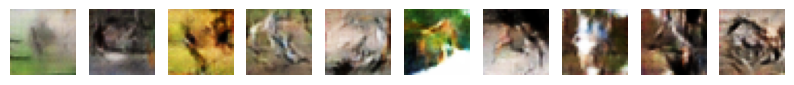

Epoch 19/20


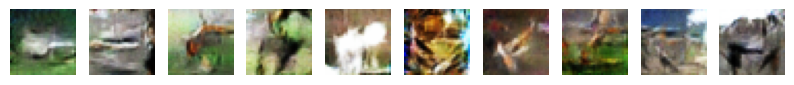

Epoch 20/20


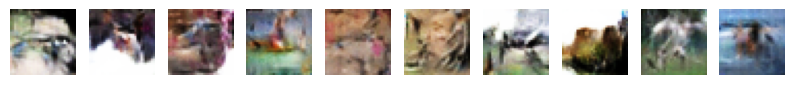

In [20]:
train_gan(gan, dataset, batch_size, d, n_epochs=20, conv=True)

#### 2.4 Generate

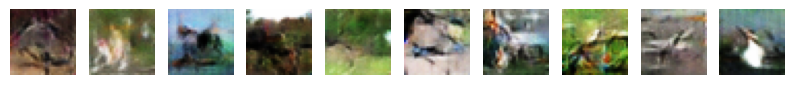

In [21]:
tf.random.set_seed(1)
np.random.seed(1)

noise = tf.random.normal(shape=[10,d])
generated_images = generator(noise)
plot_multiple_images(generated_images, 10, conv=True)

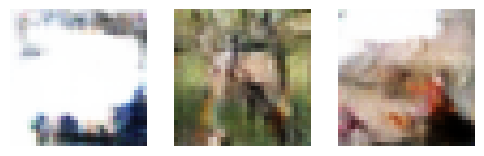

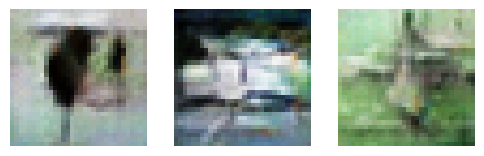

In [31]:
n, size = 3,2
noise = tf.random.normal(shape=[n,d])
generated_images = generator(noise)
plot_multiple_images(generated_images, n, size=size, conv=True)
noise = tf.random.normal(shape=[n,d])
generated_images = generator(noise)
plot_multiple_images(generated_images, n, size=size, conv=True)